In [357]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
from tqdm.notebook import tqdm

from albumentations import *
# turn off gpu for now
tf.config.set_visible_devices([], 'GPU')


In [335]:
input_path = '../input/siim-isic-melanoma-classification/'

!ls ../input/siim-isic-melanoma-classification

jpeg  sample_submission.csv  test  test.csv  tfrecords	train  train.csv


In [336]:
train_data = pd.read_csv(input_path + 'train.csv')
test_data = pd.read_csv(input_path + 'test.csv')


In [337]:
train_data

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [358]:

augmentor = (
    Compose([
        OneOf([
            ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=90,
                p=0.5),
            ElasticTransform(
                alpha=601,
                sigma=25,
                alpha_affine=10,
                p=0.5),
            GridDistortion(
                num_steps=3,
                distort_limit=0.5,
                p=0.5),
            NoOp()
        ]),
        OneOf([
            RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.5),
            RandomGamma(
                gamma_limit=(85, 115),
                p=0.5),
            NoOp()
        ]),
        OneOf([
            RGBShift(
                r_shift_limit=(-15, 15),
                g_shift_limit=(-15, 15),
                b_shift_limit=(-15, 15),
                p=0.5),
            HueSaturationValue(
                hue_shift_limit=(-15, 15),
                sat_shift_limit=(-25, 25),
                val_shift_limit=(-15, 15),
                p=0.5),
            NoOp()
        ]),
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)

def _augmentation(image, label):
    image = augmentor(image=image.numpy())['image']
    return image, label

def _parse_record(serialized):
    features = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string, default_value=''),
        'target':     tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_example(
        serialized=serialized, features=features)
    
    image = tf.io.decode_image(example['image'], channels=3)
    label = example['target']
    
    return image, label
        

def get_dataset(path, batch_size, augment=False, cache=False):
    
    if cache:
        if not(os.path.isdir('tmp/')):
            os.mkdir('tmp/')
        else:
            files = glob.glob(f'tmp/*')
            for f in files:
                os.remove(f)
        if path == 'train':
            cache_path = '../tmp/train_cache'
        else:
            cache_path = '../tmp/test_cache'
    
    
    filenames = glob.glob(input_path + 'tfrecords/' + path + '*')
    
    dataset = tf.data.TFRecordDataset(
        filenames=filenames,
        num_parallel_reads=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.map(_parse_record)
    
    if cache:
        dataset = dataset.cache(cache_path)
    
    if augment:
        dataset = dataset.map(
            lambda x, y: tf.py_function(
                func=_augmentation,
                inp=[x, y],
                Tout=[tf.uint8, tf.int64]
            ),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [359]:
dataset = get_dataset('train', 4)

In [360]:
for x in tqdm(dataset):
    pass
    #x = x['image'].numpy()[0]

KeyboardInterrupt: 

In [319]:
import matplotlib.pyplot as plt

In [352]:
x

(<tf.Tensor: shape=(4, 1024, 1024, 3), dtype=uint8, numpy=
 array([[[[188, 111, 128],
          [187, 110, 127],
          [186, 109, 126],
          ...,
          [185, 108, 116],
          [185, 108, 116],
          [184, 107, 116]],
 
         [[188, 111, 128],
          [187, 110, 127],
          [186, 109, 126],
          ...,
          [187, 110, 117],
          [186, 109, 118],
          [186, 109, 118]],
 
         [[188, 113, 127],
          [187, 112, 128],
          [187, 110, 127],
          ...,
          [184, 109, 117],
          [184, 107, 116],
          [184, 107, 116]],
 
         ...,
 
         [[168,  93,  94],
          [164,  90,  91],
          [161,  87,  90],
          ...,
          [168,  98, 100],
          [169,  96,  99],
          [168,  95,  98]],
 
         [[170,  96,  97],
          [167,  92,  93],
          [164,  90,  92],
          ...,
          [167,  96,  98],
          [168,  95,  98],
          [168,  94,  97]],
 
         [[175,  99, 101]

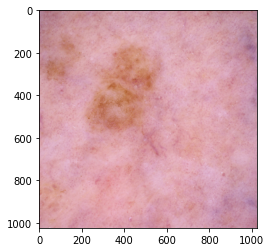

In [356]:
plt.imshow(x[0][2].numpy())